## Paper Text Mining
Here we are going to mine and process the text for a specific paper; in the end we are going to use three differents keyword extraction libraries to obtain all the main arguments described in the papers.

In [24]:
import os
import re
import shutil
from PyPDF2 import PdfFileReader

def extract_text(filename):
    #with open(pdf_path, 'rb') as f:
    f = open(filename, 'rb')
    pdf = PdfFileReader(f);
    if pdf.isEncrypted:
        try:
            pdf.decrypt('')
            print('File Decrypted (PyPDF2)')
        except:
            command = ("cp "+ filename +
                " temp.pdf; qpdf --password='' --decrypt temp.pdf " + filename
                + "; rm temp.pdf")
            os.system(command)
            print('File Decrypted (qpdf)')
            return ""
            #f = open(filename, 'rb')
            #pdf = PdfFileReader(f)
    else:
        print('File Not Encrypted')
    curtext= ""
    for i in range(0,pdf.getNumPages()):
        
        page = pdf.getPage(i)
        #print(page.extractText())
        curtext += page.extractText()
    return curtext
    
     
path = 'C:\\Users\\stefa\\OneDrive\\Desktop\\Uni\\Business\\Project\\Papers\\face_recognition_systems'
# path = 'C:\\Users\\stefa\\OneDrive\\Desktop\\Uni\\Business\\Project\\Papers\\fusion_method'
# path = 'C:\\Users\\stefa\\OneDrive\\Desktop\\Uni\\Business\\Project\\Papers\\keypoint_heatmap'
# path = 'C:\\Users\\stefa\\OneDrive\\Desktop\\Uni\\Business\\Project\\Papers\\face_cluster'
# path = 'C:\\Users\\stefa\\OneDrive\\Desktop\\Uni\\Business\\Project\\Papers\\neural_aggregation_network'
# path = 'C:\\Users\\stefa\\OneDrive\\Desktop\\Uni\\Business\\Project\\Papers\\field_view_head_mounted_display'
# path = 'C:\\Users\\stefa\\OneDrive\\Desktop\\Uni\\Business\\Project\\Papers\\feature_network'

print("Getting files...")
# getting all files from the directory given by the path
files = os.listdir(path)
# moving to the desired directory
os.chdir(path)
text = ""
cur_text = ""
# filename = 'C:\\Users\\stefa\\OneDrive\\Desktop\\Uni\\Business\\Project\\Papers\\fusion_method\\1-s2.0-S135044951730052X-main.pdf'
for filename in files:
    if filename.endswith('.pdf'):
        text += extract_text(filename); # read file content

# lower() is a Python function for strings
lower_text = ""
for pdf_text in text:
    lower_text += pdf_text.lower() #we pick each word and add to a variable, which will contain all the text

#white space removal 
def remove_whitespace(text):
    return  " ".join(text.split())

lower_text = remove_whitespace(lower_text)


#punctuation and digits removal: we replace any undesired character with a ''
for char in '?.,¡!/;:*#-~+±–—=%<>{}[]()@1234567890':  
    lower_text = lower_text.replace(char,'')

import pke

# initialize keyphrase extraction model, here TopicRank
#print("Initializing extractor...")
#extractor = pke.unsupervised.TopicRank()

# load the content of the document, here document is expected to be in raw
# format (i.e. a simple text file) and preprocessing is carried out using spacy
#print("Loading text...");
#extractor.load_document(input=lower_text, language='en')

# keyphrase candidate selection, in the case of TopicRank: sequences of nouns
# and adjectives (i.e. `(Noun|Adj)*`)
#print("Candidate Selection...")
#extractor.candidate_selection()

# candidate weighting, in the case of TopicRank: using a random walk algorithm
#print("Weighting...")
#extractor.candidate_weighting()

# N-best selection, keyphrases contains the 10 highest scored candidates as
# (keyphrase, score) tuples
#print("Selecting 10 best candidates...")
#keyphrases = extractor.get_n_best(n=10)
#for tuple in keyphrases:
#    print(tuple[0])
#    lower_text = lower_text.replace(tuple[0],'')
#print(keyphrases)

from keybert import KeyBERT
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(lower_text)
for tuple in keywords:
    print(tuple[0])
    lower_text = lower_text.replace(tuple[0],'')

print(kw_model.extract_keywords(lower_text, keyphrase_ngram_range=(1, 1), stop_words=None))

import nltk
nltk.sent_tokenize(lower_text)

# the output is a list, where each element is a token of the original text
tokenized_text = nltk.word_tokenize(lower_text)

from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')

# we prepare a empty list, which will contain the words after the stopwords removal
tokenized_vector = []

# we iterate into the list of tokens obtained through the tokenization
for token in tokenized_text:
    # if a token is not a stopword, we insert it in the list
    if token not in stopwords_en:
        tokenized_vector.append(token)

# the output is a list of all the tokens of the original text excluding the stopwords

pos_tagging = nltk.pos_tag(tokenized_vector)

cleaned_POS_text = []

for tuple in pos_tagging:
    # POS tagged text is a list of tuples, where the first element tuple[0] is a token and the second one tuple[1] is
    # the Part of Speech. If the POS has length == 1, the token is punctuation, otherwise it is not, and we insert it
    # in the list cleaned_POS_text
    if len(tuple[1]) > 1:
        cleaned_POS_text.append(tuple)

def simpler_pos_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return "a"
    elif nltk_tag.startswith('V'):
        return "v"
    elif nltk_tag.startswith('N'):
        return "n"
    elif nltk_tag.startswith('R'):
        return "r"
    else:         
        return None
    
simpler_POS_text = []

# for each tuple of the list, we create a new tuple: the first element is the token, the second is
# the simplified pos tag, obtained calling the function simpler_pos_tag()
# then we append the new created tuple to a new list, which will be the output
for tuple in cleaned_POS_text:
    if tuple[1] == 'NNP':   #this is because there is some text in japanese categorized as 'NNP';
                            #no other relevant words are categorized in such a way
        continue;
    POS_tuple = (tuple[0], simpler_pos_tag(tuple[1]))
    simpler_POS_text.append(POS_tuple)
    

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

lemmatized_text = []

for tuple in simpler_POS_text:
    if (tuple[1] == None):
        lemmatized_text.append(lemmatizer.lemmatize(tuple[0]))
    else:
        lemmatized_text.append(lemmatizer.lemmatize(tuple[0], pos=tuple[1]))

lem_text = ""
for abstract_text in lemmatized_text:
    lem_text += abstract_text + " " #we pick each word and add to a variable, which will contain all the text
lem_text

import pke
# initialize keyphrase extraction model, here TopicRank
print("Initializing extractor...")
extractor = pke.unsupervised.TopicRank()

# load the content of the document, here document is expected to be in raw
# format (i.e. a simple text file) and preprocessing is carried out using spacy
print("Loading text...");
extractor.load_document(input=lem_text, language='en')

# keyphrase candidate selection, in the case of TopicRank: sequences of nouns
# and adjectives (i.e. `(Noun|Adj)*`)
print("Candidate Selection...")
extractor.candidate_selection()

# candidate weighting, in the case of TopicRank: using a random walk algorithm
print("Weighting...")
extractor.candidate_weighting()

# N-best selection, keyphrases contains the 10 highest scored candidates as
# (keyphrase, score) tuples
print("Selecting 40 best candidates...")
keyphrases = extractor.get_n_best(n=80)
for tuple in keyphrases:
    print(tuple[0])
#print(keyphrases)

from keybert import KeyBERT
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(lem_text)
for tuple in keywords:
    print(tuple[0])

print(kw_model.extract_keywords(lem_text, keyphrase_ngram_range=(1, 1), stop_words=None))

from rake_nltk import Rake

# Uses stopwords for english from NLTK, and all puntuation characters by
# default
#r = Rake()

# Extraction given the text.
#r.extract_keywords_from_text(lem_text)

# To get keyword phrases ranked highest to lowest.
#r.get_ranked_phrases()

# To get keyword phrases ranked highest to lowest with scores.
#r.get_ranked_phrases_with_scores()



Getting files...
File Not Encrypted


C:\Users\stefa\anaconda3\lib\site-packages\PyPDF2\_reader.py:1351: PdfReadWarning: Xref table not zero-indexed. ID numbers for objects will be corrected.
  warnings.warn(


File Not Encrypted
File Not Encrypted
File Not Encrypted
File Not Encrypted
File Not Encrypted
File Not Encrypted
File Not Encrypted
discriminantvectors
discriminantvector
discriminant
recognitiondetection
lda
[('facerecognition', 0.4374), ('recognitions', 0.4053), ('recognitionpp', 0.4014), ('recognition', 0.4005), ('recognitionperformance', 0.3931)]
Initializing extractor...
Loading text...
Candidate Selection...
Weighting...
Selecting 40 best candidates...
performance face recognition system signi
face catch
recognition method
et al
correspond recognition rate
highdimensional sample
algorithm
feature testing image
thepdimensional image
illumination
test
class containsm sample letykmdenote
accurate stable method
resolution use
data
database
face image
person
ed fisher
subject test face image
work theorem
recognition society
feature vector ofxkmthrough transformationqqt ykm
catch system
vector
problem
template ieee
thesmall sample size problem paper
database frontal facial image
secti

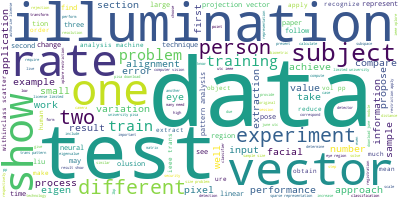

In [26]:
from wordcloud import WordCloud
lem_text = lem_text.replace("face",'')
lem_text = lem_text.replace("image",'')
lem_text = lem_text.replace("use",'')
lem_text = lem_text.replace("fig",'')
lem_text = lem_text.replace("system",'')
lem_text = lem_text.replace("method",'')
lem_text = lem_text.replace("pca",'')
lem_text = lem_text.replace("base",'')
lem_text = lem_text.replace("keypoint",'')
lem_text = lem_text.replace("heatmap",'')
lem_text = lem_text.replace("cc",'')
lem_text = lem_text.replace("algorithms",'')
lem_text = lem_text.replace("algorithm",'')
lem_text = lem_text.replace("network",'')
lem_text = lem_text.replace("feature",'')
lem_text = lem_text.replace("model",'')
lem_text = lem_text.replace("recognition",'')
lem_text = lem_text.replace("set",'')
lem_text = lem_text.replace("cluster",'')
lem_text = lem_text.replace("ccc",'')
lem_text = re.sub(r"\b\d+\b *|\b[a-z]\b *","",lem_text)
lem_text = re.sub(r"\bet al\b *","",lem_text)
lem_text = re.sub(r"\bdn\b *","",lem_text)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(lem_text)
# Visualize the word cloud
wordcloud.to_image()